In [13]:
# Well, I have done it. It's layered cluster
# Unfortunately, it's not any faster....

from PIL import Image
import pickle
import vocabulary
import os
from pylab import *
from numpy import *
from scipy.cluster.vq import *

In [2]:
import sift
import imagesearch3
imagesearch3 = reload(imagesearch3)
import mysparse
mysparse = reload(mysparse)

In [3]:
with open('caltech_imlist.pkl', 'rb') as f:
    imlist = pickle.load(f)
    featlist = pickle.load(f)

In [53]:
nbr_features = len(featlist)
descr = []
feature = sift.read_features_from_file(featlist[0])[1]
descr.append(feature[4:])
descriptors = descr[0]  # stack all features for k-means
for i in arange(1, nbr_features):
    feature = sift.read_features_from_file(featlist[i])[1]
    descr.append(feature[4:])
    descriptors = vstack((descriptors, descr[i]))

In [55]:
descriptors_short = descriptors[::100]
print descriptors_short.shape

(6304, 128)


In [167]:
cnt=0
word_list=[]
def divide_branch_with_center(data, branch, k, min_size, depth):
    global cnt
    # print depth, ':', len(branch)
    div = min(k, len(branch))
    if (div<=1) or (len(branch)<=min_size):
        return []
    centroids, distortion = kmeans(data[branch], k)
    code, distance = vq(data[branch], centroids)
    new_branch = []
    for i in range(k):
        ind = where(code==i)[0]
        if len(ind)==0:
            continue
        else:
            cnt += 1
            word_list.append(centroids[i])
            new_branch.append((centroids[i], distance[i], divide_branch_with_center(data, branch[ind], k, min_size, depth+1), cnt-1))
    return new_branch

In [168]:
import sys
sys.setrecursionlimit(10000)

In [169]:
min_size = min(10, int(descriptors_short.shape[0]/100))
tree = array([i for i in range(descriptors_short.shape[0])])
cnt=0
word_list=[]
branches = ([0]*descriptors_short.shape[1], 0, divide_branch_with_center(descriptors, tree, 4, min_size, 0))

In [170]:
feature = sift.read_features_from_file(featlist[0])[1]
loc, desc = feature[:4], feature[4:]

In [171]:
print desc

[[  11.    1.    0. ...,    0.    0.    5.]
 [   3.    1.    4. ...,    3.    0.    0.]
 [ 120.    1.    1. ...,    0.    0.    1.]
 ..., 
 [   0.    0.    0. ...,    4.    2.    0.]
 [   0.    0.    0. ...,   96.   19.   39.]
 [  42.  102.   21. ...,    0.    0.    4.]]


In [172]:
def get_distance(l1, l2):
    try:
        return sqrt(sum([(i1-i2)**2 for i1, i2 in zip(l1, l2)]))
    except:
        print l1, l2
        raise

In [176]:
def get_word(node, d):
    if len(node[2])==0:
        return node[3]
    min_distance = get_distance(node[2][0][0], d)
    next_node = 0
    for i in arange(1, len(node)):
        distance = get_distance(node[2][i][0], d)
        if (distance<min_distance):
            min_distance = distance
            next_node = i
    return get_word(node[2][next_node], d)

In [178]:
node = branches
print get_word(node, desc[0])
print word_list[927]

927
[  11.    1.    0.    0.    0.    0.    0.   12.  149.    0.    0.    0.
    0.    0.    0.   33.  177.   28.   10.    0.    0.    0.    0.   21.
   15.   82.   25.    0.    0.    0.    0.    0.   17.    3.    0.    0.
    0.    0.    0.    6.  177.    5.    0.    0.    0.    0.    0.   20.
  177.   24.    0.    0.    0.    0.    0.   23.   59.   38.    1.    0.
    0.    0.    0.    1.   26.    3.    0.    0.    0.    0.    0.    3.
  164.   27.    0.    0.    0.    0.    0.    7.  177.   25.    0.    0.
    0.    0.    0.   22.   70.    7.    0.    0.    0.    0.    0.   10.
   23.    0.    0.    0.    0.    0.    0.    4.  141.   17.    0.    0.
    0.    0.    0.   12.  177.   59.    0.    0.    0.    0.    0.   25.
   64.   16.    0.    0.    0.    0.    0.    5.]


In [190]:
class vocabulary4:
    
    def __init__(self, node, word_list, name):
        self.node = node
        self.word_list = word_list
        self.name = name
    
    def project(self, d):
        nbr_words = len(self.word_list)
        imhist = zeros((nbr_words))
        for d0 in d:
            w = get_word(self.node, d0)
            imhist[w]+=1
        return imhist
    
    def get_word(self, node, d):
        if len(node[2])==0:
            return node[3]
        min_distance = get_distance(node[2][0][0], d)
        next_node = 0
        for i in arange(1, len(node)):
            distance = get_distance(node[2][i][0], d)
            if (distance<min_distance):
                min_distance = distance
                next_node = i
        return get_word(node[2][next_node], d)    

In [192]:
voc = vocabulary4(branches, word_list, "clustered vocabulary")
h = voc.project(desc)

In [194]:
import imagesearch
imagesearch = reload(imagesearch)
os.remove('test4.db')
indx = imagesearch.Indexer('test4.db', voc)
indx.create_tables()

In [195]:
def average_color(imn):
    im = array(Image.open(imn))
    if size(im.shape)>2:
        col = [int(average(im[:, :, c])+0.5) for c in [0, 1, 2]]
    else:
        col = [128, 128, 128]
    return col

In [196]:
for i in range(nbr_images):
    locs, descr = sift.read_features_from_file(featlist[i])
    indx.add_to_index(imlist[i], descr)
    indx.add_to_index_color(imlist[i], average_color(imlist[i]))
indx.db_commit()

indexing ./101_ObjectCategories/binocular/image_0018.jpg
indexing ./101_ObjectCategories/binocular/image_0018.jpg  color
indexing ./101_ObjectCategories/binocular/image_0016.jpg
indexing ./101_ObjectCategories/binocular/image_0016.jpg  color
indexing ./101_ObjectCategories/binocular/image_0024.jpg
indexing ./101_ObjectCategories/binocular/image_0024.jpg  color
indexing ./101_ObjectCategories/binocular/image_0027.jpg
indexing ./101_ObjectCategories/binocular/image_0027.jpg  color
indexing ./101_ObjectCategories/binocular/image_0023.jpg
indexing ./101_ObjectCategories/binocular/image_0023.jpg  color
indexing ./101_ObjectCategories/binocular/image_0017.jpg
indexing ./101_ObjectCategories/binocular/image_0017.jpg  color
indexing ./101_ObjectCategories/binocular/image_0022.jpg
indexing ./101_ObjectCategories/binocular/image_0022.jpg  color
indexing ./101_ObjectCategories/garfield/image_0005.jpg
indexing ./101_ObjectCategories/garfield/image_0005.jpg  color
indexing ./101_ObjectCategories/ga

indexing ./101_ObjectCategories/helicopter/image_0071.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0041.jpg
indexing ./101_ObjectCategories/helicopter/image_0041.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0020.jpg
indexing ./101_ObjectCategories/helicopter/image_0020.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0033.jpg
indexing ./101_ObjectCategories/helicopter/image_0033.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0030.jpg
indexing ./101_ObjectCategories/helicopter/image_0030.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0007.jpg
indexing ./101_ObjectCategories/helicopter/image_0007.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0027.jpg
indexing ./101_ObjectCategories/helicopter/image_0027.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0073.jpg
indexing ./101_ObjectCategories/helicopter/image_0073.jpg  color
indexing ./101_ObjectCategories/helicopter/image_0001.jpg
indexing ./101_O

indexing ./101_ObjectCategories/crocodile/image_0035.jpg  color
indexing ./101_ObjectCategories/crocodile/image_0017.jpg
indexing ./101_ObjectCategories/crocodile/image_0017.jpg  color
indexing ./101_ObjectCategories/crocodile/image_0002.jpg
indexing ./101_ObjectCategories/crocodile/image_0002.jpg  color
indexing ./101_ObjectCategories/ibis/image_0042.jpg
indexing ./101_ObjectCategories/ibis/image_0042.jpg  color
indexing ./101_ObjectCategories/ibis/image_0050.jpg
indexing ./101_ObjectCategories/ibis/image_0050.jpg  color
indexing ./101_ObjectCategories/ibis/image_0005.jpg
indexing ./101_ObjectCategories/ibis/image_0005.jpg  color
indexing ./101_ObjectCategories/ibis/image_0014.jpg
indexing ./101_ObjectCategories/ibis/image_0014.jpg  color
indexing ./101_ObjectCategories/ibis/image_0020.jpg
indexing ./101_ObjectCategories/ibis/image_0020.jpg  color
indexing ./101_ObjectCategories/ibis/image_0076.jpg
indexing ./101_ObjectCategories/ibis/image_0076.jpg  color
indexing ./101_ObjectCategor

indexing ./101_ObjectCategories/crab/image_0049.jpg  color
indexing ./101_ObjectCategories/crab/image_0070.jpg
indexing ./101_ObjectCategories/crab/image_0070.jpg  color
indexing ./101_ObjectCategories/crab/image_0068.jpg
indexing ./101_ObjectCategories/crab/image_0068.jpg  color
indexing ./101_ObjectCategories/crab/image_0033.jpg
indexing ./101_ObjectCategories/crab/image_0033.jpg  color
indexing ./101_ObjectCategories/crab/image_0003.jpg
indexing ./101_ObjectCategories/crab/image_0003.jpg  color
indexing ./101_ObjectCategories/crab/image_0026.jpg
indexing ./101_ObjectCategories/crab/image_0026.jpg  color
indexing ./101_ObjectCategories/crab/image_0034.jpg
indexing ./101_ObjectCategories/crab/image_0034.jpg  color
indexing ./101_ObjectCategories/crab/image_0037.jpg
indexing ./101_ObjectCategories/crab/image_0037.jpg  color
indexing ./101_ObjectCategories/crab/image_0056.jpg
indexing ./101_ObjectCategories/crab/image_0056.jpg  color
indexing ./101_ObjectCategories/crab/image_0008.jpg
i

indexing ./101_ObjectCategories/watch/image_0135.jpg  color
indexing ./101_ObjectCategories/watch/image_0064.jpg
indexing ./101_ObjectCategories/watch/image_0064.jpg  color
indexing ./101_ObjectCategories/watch/image_0156.jpg
indexing ./101_ObjectCategories/watch/image_0156.jpg  color
indexing ./101_ObjectCategories/watch/image_0155.jpg
indexing ./101_ObjectCategories/watch/image_0155.jpg  color
indexing ./101_ObjectCategories/watch/image_0138.jpg
indexing ./101_ObjectCategories/watch/image_0138.jpg  color
indexing ./101_ObjectCategories/watch/image_0137.jpg
indexing ./101_ObjectCategories/watch/image_0137.jpg  color
indexing ./101_ObjectCategories/watch/image_0107.jpg
indexing ./101_ObjectCategories/watch/image_0107.jpg  color
indexing ./101_ObjectCategories/watch/image_0012.jpg
indexing ./101_ObjectCategories/watch/image_0012.jpg  color
indexing ./101_ObjectCategories/watch/image_0185.jpg
indexing ./101_ObjectCategories/watch/image_0185.jpg  color
indexing ./101_ObjectCategories/watc

indexing ./101_ObjectCategories/snoopy/image_0018.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0016.jpg
indexing ./101_ObjectCategories/snoopy/image_0016.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0024.jpg
indexing ./101_ObjectCategories/snoopy/image_0024.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0027.jpg
indexing ./101_ObjectCategories/snoopy/image_0027.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0001.jpg
indexing ./101_ObjectCategories/snoopy/image_0001.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0012.jpg
indexing ./101_ObjectCategories/snoopy/image_0012.jpg  color
indexing ./101_ObjectCategories/snoopy/image_0032.jpg
indexing ./101_ObjectCategories/snoopy/image_0032.jpg  color
indexing ./101_ObjectCategories/cup/image_0042.jpg
indexing ./101_ObjectCategories/cup/image_0042.jpg  color
indexing ./101_ObjectCategories/cup/image_0057.jpg
indexing ./101_ObjectCategories/cup/image_0057.jpg  color
indexing ./101_ObjectCategories

indexing ./101_ObjectCategories/elephant/image_0025.jpg  color
indexing ./101_ObjectCategories/elephant/image_0019.jpg
indexing ./101_ObjectCategories/elephant/image_0019.jpg  color
indexing ./101_ObjectCategories/elephant/image_0021.jpg
indexing ./101_ObjectCategories/elephant/image_0021.jpg  color
indexing ./101_ObjectCategories/elephant/image_0009.jpg
indexing ./101_ObjectCategories/elephant/image_0009.jpg  color
indexing ./101_ObjectCategories/elephant/image_0059.jpg
indexing ./101_ObjectCategories/elephant/image_0059.jpg  color
indexing ./101_ObjectCategories/elephant/image_0031.jpg
indexing ./101_ObjectCategories/elephant/image_0031.jpg  color
indexing ./101_ObjectCategories/schooner/image_0050.jpg
indexing ./101_ObjectCategories/schooner/image_0050.jpg  color
indexing ./101_ObjectCategories/schooner/image_0038.jpg
indexing ./101_ObjectCategories/schooner/image_0038.jpg  color
indexing ./101_ObjectCategories/schooner/image_0061.jpg
indexing ./101_ObjectCategories/schooner/image_0

indexing ./101_ObjectCategories/windsor_chair/image_0037.jpg  color
indexing ./101_ObjectCategories/windsor_chair/image_0019.jpg
indexing ./101_ObjectCategories/windsor_chair/image_0019.jpg  color
indexing ./101_ObjectCategories/windsor_chair/image_0021.jpg
indexing ./101_ObjectCategories/windsor_chair/image_0021.jpg  color
indexing ./101_ObjectCategories/windsor_chair/image_0032.jpg
indexing ./101_ObjectCategories/windsor_chair/image_0032.jpg  color
indexing ./101_ObjectCategories/windsor_chair/image_0013.jpg
indexing ./101_ObjectCategories/windsor_chair/image_0013.jpg  color
indexing ./101_ObjectCategories/camera/image_0018.jpg
indexing ./101_ObjectCategories/camera/image_0018.jpg  color
indexing ./101_ObjectCategories/camera/image_0038.jpg
indexing ./101_ObjectCategories/camera/image_0038.jpg  color
indexing ./101_ObjectCategories/camera/image_0016.jpg
indexing ./101_ObjectCategories/camera/image_0016.jpg  color
indexing ./101_ObjectCategories/camera/image_0030.jpg
indexing ./101_Ob

indexing ./101_ObjectCategories/flamingo/image_0020.jpg
indexing ./101_ObjectCategories/flamingo/image_0020.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0058.jpg
indexing ./101_ObjectCategories/flamingo/image_0058.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0024.jpg
indexing ./101_ObjectCategories/flamingo/image_0024.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0044.jpg
indexing ./101_ObjectCategories/flamingo/image_0044.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0043.jpg
indexing ./101_ObjectCategories/flamingo/image_0043.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0001.jpg
indexing ./101_ObjectCategories/flamingo/image_0001.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0047.jpg
indexing ./101_ObjectCategories/flamingo/image_0047.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0060.jpg
indexing ./101_ObjectCategories/flamingo/image_0060.jpg  color
indexing ./101_ObjectCategories/flamingo/image_0

indexing ./101_ObjectCategories/inline_skate/image_0002.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0176.jpg
indexing ./101_ObjectCategories/Leopards/image_0176.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0172.jpg
indexing ./101_ObjectCategories/Leopards/image_0172.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0112.jpg
indexing ./101_ObjectCategories/Leopards/image_0112.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0006.jpg
indexing ./101_ObjectCategories/Leopards/image_0006.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0084.jpg
indexing ./101_ObjectCategories/Leopards/image_0084.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0078.jpg
indexing ./101_ObjectCategories/Leopards/image_0078.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0057.jpg
indexing ./101_ObjectCategories/Leopards/image_0057.jpg  color
indexing ./101_ObjectCategories/Leopards/image_0071.jpg
indexing ./101_ObjectCategories/Leopards/ima

indexing ./101_ObjectCategories/scorpion/image_0082.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0047.jpg
indexing ./101_ObjectCategories/scorpion/image_0047.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0021.jpg
indexing ./101_ObjectCategories/scorpion/image_0021.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0048.jpg
indexing ./101_ObjectCategories/scorpion/image_0048.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0080.jpg
indexing ./101_ObjectCategories/scorpion/image_0080.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0022.jpg
indexing ./101_ObjectCategories/scorpion/image_0022.jpg  color
indexing ./101_ObjectCategories/scorpion/image_0065.jpg
indexing ./101_ObjectCategories/scorpion/image_0065.jpg  color
indexing ./101_ObjectCategories/pigeon/image_0005.jpg
indexing ./101_ObjectCategories/pigeon/image_0005.jpg  color
indexing ./101_ObjectCategories/pigeon/image_0020.jpg
indexing ./101_ObjectCategories/pigeon/image_0020.jpg 

indexing ./101_ObjectCategories/dollar_bill/image_0026.jpg  color
indexing ./101_ObjectCategories/dollar_bill/image_0011.jpg
indexing ./101_ObjectCategories/dollar_bill/image_0011.jpg  color
indexing ./101_ObjectCategories/dollar_bill/image_0001.jpg
indexing ./101_ObjectCategories/dollar_bill/image_0001.jpg  color
indexing ./101_ObjectCategories/dollar_bill/image_0008.jpg
indexing ./101_ObjectCategories/dollar_bill/image_0008.jpg  color
indexing ./101_ObjectCategories/dollar_bill/image_0028.jpg
indexing ./101_ObjectCategories/dollar_bill/image_0028.jpg  color
indexing ./101_ObjectCategories/dollar_bill/image_0022.jpg
indexing ./101_ObjectCategories/dollar_bill/image_0022.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0408.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0408.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0176.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0176.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0412.jpg
index

indexing ./101_ObjectCategories/Faces_easy/image_0193.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0193.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0397.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0397.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0386.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0386.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0270.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0270.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0259.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0259.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0175.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0175.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0183.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0183.jpg  color
indexing ./101_ObjectCategories/Faces_easy/image_0283.jpg
indexing ./101_ObjectCategories/Faces_easy/image_0283.jpg  color
indexing ./101_O

indexing ./101_ObjectCategories/hedgehog/image_0004.jpg  color
indexing ./101_ObjectCategories/hedgehog/image_0019.jpg
indexing ./101_ObjectCategories/hedgehog/image_0019.jpg  color
indexing ./101_ObjectCategories/hedgehog/image_0021.jpg
indexing ./101_ObjectCategories/hedgehog/image_0021.jpg  color
indexing ./101_ObjectCategories/hedgehog/image_0032.jpg
indexing ./101_ObjectCategories/hedgehog/image_0032.jpg  color
indexing ./101_ObjectCategories/hedgehog/image_0013.jpg
indexing ./101_ObjectCategories/hedgehog/image_0013.jpg  color
indexing ./101_ObjectCategories/ant/image_0018.jpg
indexing ./101_ObjectCategories/ant/image_0018.jpg  color
indexing ./101_ObjectCategories/ant/image_0014.jpg
indexing ./101_ObjectCategories/ant/image_0014.jpg  color
indexing ./101_ObjectCategories/ant/image_0033.jpg
indexing ./101_ObjectCategories/ant/image_0033.jpg  color
indexing ./101_ObjectCategories/ant/image_0010.jpg
indexing ./101_ObjectCategories/ant/image_0010.jpg  color
indexing ./101_ObjectCate

indexing ./101_ObjectCategories/crayfish/image_0045.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0030.jpg
indexing ./101_ObjectCategories/crayfish/image_0030.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0007.jpg
indexing ./101_ObjectCategories/crayfish/image_0007.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0027.jpg
indexing ./101_ObjectCategories/crayfish/image_0027.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0037.jpg
indexing ./101_ObjectCategories/crayfish/image_0037.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0056.jpg
indexing ./101_ObjectCategories/crayfish/image_0056.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0008.jpg
indexing ./101_ObjectCategories/crayfish/image_0008.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0048.jpg
indexing ./101_ObjectCategories/crayfish/image_0048.jpg  color
indexing ./101_ObjectCategories/crayfish/image_0046.jpg
indexing ./101_ObjectCategories/crayfish/image_0

indexing ./101_ObjectCategories/pizza/image_0047.jpg  color
indexing ./101_ObjectCategories/pizza/image_0048.jpg
indexing ./101_ObjectCategories/pizza/image_0048.jpg  color
indexing ./101_ObjectCategories/pizza/image_0046.jpg
indexing ./101_ObjectCategories/pizza/image_0046.jpg  color
indexing ./101_ObjectCategories/pizza/image_0051.jpg
indexing ./101_ObjectCategories/pizza/image_0051.jpg  color
indexing ./101_ObjectCategories/dolphin/image_0018.jpg
indexing ./101_ObjectCategories/dolphin/image_0018.jpg  color
indexing ./101_ObjectCategories/dolphin/image_0049.jpg
indexing ./101_ObjectCategories/dolphin/image_0049.jpg  color
indexing ./101_ObjectCategories/dolphin/image_0041.jpg
indexing ./101_ObjectCategories/dolphin/image_0041.jpg  color
indexing ./101_ObjectCategories/dolphin/image_0015.jpg
indexing ./101_ObjectCategories/dolphin/image_0015.jpg  color
indexing ./101_ObjectCategories/dolphin/image_0054.jpg
indexing ./101_ObjectCategories/dolphin/image_0054.jpg  color
indexing ./101_O

indexing ./101_ObjectCategories/Motorbikes/image_0360.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0709.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0709.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0143.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0143.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0251.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0251.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0296.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0296.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0501.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0501.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0130.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0130.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0018.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0018.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0776.jpg
indexing ./101_O

indexing ./101_ObjectCategories/Motorbikes/image_0134.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0759.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0759.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0328.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0328.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0379.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0379.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0029.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0029.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0195.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0195.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0528.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0528.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0356.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0356.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0700.jpg
indexing ./101_O

indexing ./101_ObjectCategories/Motorbikes/image_0454.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0072.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0072.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0108.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0108.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0197.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0197.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0265.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0265.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0415.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0415.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0605.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0605.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0585.jpg
indexing ./101_ObjectCategories/Motorbikes/image_0585.jpg  color
indexing ./101_ObjectCategories/Motorbikes/image_0180.jpg
indexing ./101_O

indexing ./101_ObjectCategories/cannon/image_0002.jpg  color
indexing ./101_ObjectCategories/menorah/image_0042.jpg
indexing ./101_ObjectCategories/menorah/image_0042.jpg  color
indexing ./101_ObjectCategories/menorah/image_0050.jpg
indexing ./101_ObjectCategories/menorah/image_0050.jpg  color
indexing ./101_ObjectCategories/menorah/image_0049.jpg
indexing ./101_ObjectCategories/menorah/image_0049.jpg  color
indexing ./101_ObjectCategories/menorah/image_0070.jpg
indexing ./101_ObjectCategories/menorah/image_0070.jpg  color
indexing ./101_ObjectCategories/menorah/image_0068.jpg
indexing ./101_ObjectCategories/menorah/image_0068.jpg  color
indexing ./101_ObjectCategories/menorah/image_0087.jpg
indexing ./101_ObjectCategories/menorah/image_0087.jpg  color
indexing ./101_ObjectCategories/menorah/image_0039.jpg
indexing ./101_ObjectCategories/menorah/image_0039.jpg  color
indexing ./101_ObjectCategories/menorah/image_0055.jpg
indexing ./101_ObjectCategories/menorah/image_0055.jpg  color
ind

indexing ./101_ObjectCategories/Faces/image_0097.jpg  color
indexing ./101_ObjectCategories/Faces/image_0347.jpg
indexing ./101_ObjectCategories/Faces/image_0347.jpg  color
indexing ./101_ObjectCategories/Faces/image_0139.jpg
indexing ./101_ObjectCategories/Faces/image_0139.jpg  color
indexing ./101_ObjectCategories/Faces/image_0010.jpg
indexing ./101_ObjectCategories/Faces/image_0010.jpg  color
indexing ./101_ObjectCategories/Faces/image_0328.jpg
indexing ./101_ObjectCategories/Faces/image_0328.jpg  color
indexing ./101_ObjectCategories/Faces/image_0069.jpg
indexing ./101_ObjectCategories/Faces/image_0069.jpg  color
indexing ./101_ObjectCategories/Faces/image_0292.jpg
indexing ./101_ObjectCategories/Faces/image_0292.jpg  color
indexing ./101_ObjectCategories/Faces/image_0370.jpg
indexing ./101_ObjectCategories/Faces/image_0370.jpg  color
indexing ./101_ObjectCategories/Faces/image_0011.jpg
indexing ./101_ObjectCategories/Faces/image_0011.jpg  color
indexing ./101_ObjectCategories/Face

indexing ./101_ObjectCategories/brain/image_0001.jpg  color
indexing ./101_ObjectCategories/brain/image_0019.jpg
indexing ./101_ObjectCategories/brain/image_0019.jpg  color
indexing ./101_ObjectCategories/brain/image_0083.jpg
indexing ./101_ObjectCategories/brain/image_0083.jpg  color
indexing ./101_ObjectCategories/brain/image_0060.jpg
indexing ./101_ObjectCategories/brain/image_0060.jpg  color
indexing ./101_ObjectCategories/brain/image_0017.jpg
indexing ./101_ObjectCategories/brain/image_0017.jpg  color
indexing ./101_ObjectCategories/brain/image_0046.jpg
indexing ./101_ObjectCategories/brain/image_0046.jpg  color
indexing ./101_ObjectCategories/brain/image_0022.jpg
indexing ./101_ObjectCategories/brain/image_0022.jpg  color
indexing ./101_ObjectCategories/brain/image_0036.jpg
indexing ./101_ObjectCategories/brain/image_0036.jpg  color
indexing ./101_ObjectCategories/ewer/image_0075.jpg
indexing ./101_ObjectCategories/ewer/image_0075.jpg  color
indexing ./101_ObjectCategories/ewer/i

indexing ./101_ObjectCategories/airplanes/image_0557.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0321.jpg
indexing ./101_ObjectCategories/airplanes/image_0321.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0360.jpg
indexing ./101_ObjectCategories/airplanes/image_0360.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0709.jpg
indexing ./101_ObjectCategories/airplanes/image_0709.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0143.jpg
indexing ./101_ObjectCategories/airplanes/image_0143.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0251.jpg
indexing ./101_ObjectCategories/airplanes/image_0251.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0296.jpg
indexing ./101_ObjectCategories/airplanes/image_0296.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0501.jpg
indexing ./101_ObjectCategories/airplanes/image_0501.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0130.jpg
indexing ./101_ObjectCategories/

indexing ./101_ObjectCategories/airplanes/image_0326.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0319.jpg
indexing ./101_ObjectCategories/airplanes/image_0319.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0007.jpg
indexing ./101_ObjectCategories/airplanes/image_0007.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0026.jpg
indexing ./101_ObjectCategories/airplanes/image_0026.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0497.jpg
indexing ./101_ObjectCategories/airplanes/image_0497.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0758.jpg
indexing ./101_ObjectCategories/airplanes/image_0758.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0568.jpg
indexing ./101_ObjectCategories/airplanes/image_0568.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0560.jpg
indexing ./101_ObjectCategories/airplanes/image_0560.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0337.jpg
indexing ./101_ObjectCategories/

indexing ./101_ObjectCategories/airplanes/image_0343.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0755.jpg
indexing ./101_ObjectCategories/airplanes/image_0755.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0212.jpg
indexing ./101_ObjectCategories/airplanes/image_0212.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0188.jpg
indexing ./101_ObjectCategories/airplanes/image_0188.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0013.jpg
indexing ./101_ObjectCategories/airplanes/image_0013.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0460.jpg
indexing ./101_ObjectCategories/airplanes/image_0460.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0411.jpg
indexing ./101_ObjectCategories/airplanes/image_0411.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0796.jpg
indexing ./101_ObjectCategories/airplanes/image_0796.jpg  color
indexing ./101_ObjectCategories/airplanes/image_0213.jpg
indexing ./101_ObjectCategories/

indexing ./101_ObjectCategories/mayfly/image_0036.jpg  color


In [197]:
from sqlite3 import dbapi2 as sqlite
con = sqlite.connect('test4.db')
print con.execute('select count (filename) from imlist').fetchone()
print con.execute('select * from imlist').fetchone()
print con.execute('select col0, col1, col2 from imcolor where imid=1000').fetchone()

(1736,)
(u'./101_ObjectCategories/binocular/image_0018.jpg',)
(234, 236, 232)


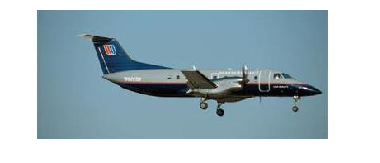

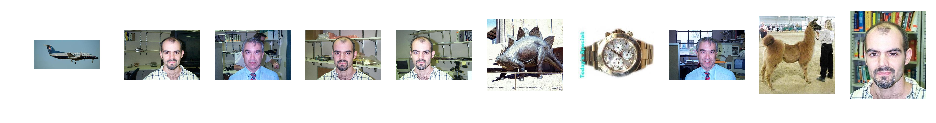

In [198]:
imid = 1525
figure()
imshow(Image.open(imlist[imid-1]))
axis('off')
show()
nbr_results = 10
imagesearch = reload(imagesearch)
src = imagesearch.Searcher('test4.db', voc)
res = [w[1] for w in src.query(imlist[imid-1])[:nbr_results]]
imagesearch.plot_results(src, res, figsize=(16, 8))